# Laporan Analisis Pleiades — HDBSCAN

Notebook ini menyajikan ringkasan end-to-end:
- Memuat konfigurasi & hasil klasterisasi
- Sanity check (ukuran klaster, proporsi noise/anggota)
- Visualisasi utama (Sky, PM plane, CMD, dsb.)
- Panel 3×3 per klaster (style notebook eksperimen)
- Perbandingan dengan katalog **valid** 
- Ekspor **daftar anggota final** (CSV)

> Disarankan membuka notebook dari VS Code (WSL) dengan kernel environment yang sama seperti CLI Anda.


In [1]:
# === Pastikan working directory = root repo (SESUAIKAN path di bawah jika perlu) ===
%cd /mnt/e/IT/Machine_Learning/PROJECT/pleiades-hdbscan

# Tambahkan src/ ke sys.path agar 'pleiades' bisa diimport
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd() / "src"))

# Import modul eksternal & internal
%matplotlib inline
import warnings, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml

from pleiades import plotting as P
from pleiades import validation as V

plt.rcParams["figure.dpi"] = 130
pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 160)

print("Repo root:", Path.cwd())
print("OK: pleiades terimport dari", Path.cwd() / "src" / "pleiades")


/mnt/e/IT/Machine_Learning/PROJECT/pleiades-hdbscan
Repo root: /mnt/e/IT/Machine_Learning/PROJECT/pleiades-hdbscan
OK: pleiades terimport dari /mnt/e/IT/Machine_Learning/PROJECT/pleiades-hdbscan/src/pleiades


In [2]:
# ==== PARAMETER YANG MUDAH DISESUAIKAN ====
CONFIG_PATH   = Path("configs/default.yaml")     # file konfigurasi proyek
INPUT_FILE    = None  # contoh: Path("data/processed/gaia_clustered.csv") atau None utk auto-detect
PROB_THRESH   = None  # None -> ambil dari config; atau set mis. 0.5
PANELS_FOR    = "all" # "all" atau list label klaster, mis. [0,1]
MAX_PANELS    = 6     # batasi berapa cluster (non-noise) yang dipanelkan (agar tidak kebanyakan)
SAVE_MEMBERS  = True  # simpan CSV anggota final
EXPORT_PATH   = Path("data/processed/pleiades_members_final.csv")

# ==== Load konfigurasi & path ====
def load_config(path: Path | None) -> dict:
    cfg = {}
    if path and path.exists():
        with open(path, "r", encoding="utf-8") as f:
            cfg = yaml.safe_load(f) or {}
    cfg.setdefault("paths", {})
    cfg["paths"].setdefault("processed", "data/processed")
    cfg["paths"].setdefault("figures",   "data/processed/figures")
    cfg["paths"].setdefault("models",    "models")
    cfg.setdefault("cluster", {})
    cfg["cluster"].setdefault("prob_min", 0.5)
    cfg.setdefault("plot", {})
    cfg["plot"].setdefault("max_arrows", 800)
    return cfg

CFG       = load_config(CONFIG_PATH)
PROC_DIR  = Path(CFG["paths"]["processed"])
FIG_DIR   = Path(CFG["paths"]["figures"])
MODELS_DIR= Path(CFG["paths"]["models"])
FIG_DIR.mkdir(parents=True, exist_ok=True)

if PROB_THRESH is None:
    PROB_THRESH = float(CFG["cluster"]["prob_min"])

print("Processed dir:", PROC_DIR)
print("Figures   dir:", FIG_DIR)
print("Models    dir:", MODELS_DIR)
print("Prob. thresh:", PROB_THRESH)


Processed dir: data/processed
Figures   dir: data/processed/figures
Models    dir: models
Prob. thresh: 0.5


In [3]:
from typing import Optional

def find_processed_file(proc_dir: Path, explicit: Optional[Path] = None) -> Path:
    if explicit is not None:
        p = explicit if explicit.is_absolute() else (proc_dir / explicit)
        if p.exists():
            return p
        raise FileNotFoundError(f"--input menunjuk ke file yang tidak ada: {p}")

    patterns = [
        "*cluster*.parquet", "*label*.parquet",
        "*cluster*.csv*",   "*label*.csv*",
        "*.parquet", "*.csv*",
    ]
    candidates = []
    for pat in patterns:
        candidates.extend(sorted(proc_dir.glob(pat)))
    if not candidates:
        raise FileNotFoundError(
            f"Tidak ada file parquet/csv di {proc_dir}.\n"
            f"Jalankan 01_preprocess.py & 02_cluster.py, atau atur INPUT_FILE."
        )
    candidates.sort(key=lambda p: p.stat().st_mtime, reverse=True)
    return candidates[0]

def prepare_dataframe(df: pd.DataFrame, prob_thresh: float) -> pd.DataFrame:
    # Harmonisasi nama kolom (selaras dengan scripts/04_make_figures.py)
    ren = {}
    if "probability" in df.columns and "prob" not in df.columns: ren["probability"] = "prob"
    if "cluster_label" in df.columns and "cluster" not in df.columns: ren["cluster_label"] = "cluster"
    if "BP_RP" in df.columns and "color" not in df.columns: ren["BP_RP"] = "color"
    if "bp_rp" in df.columns and "color" not in df.columns: ren["bp_rp"] = "color"
    if "abs_g" in df.columns and "M_G" not in df.columns: ren["abs_g"] = "M_G"
    if "RA" in df.columns and "ra" not in df.columns: ren["RA"] = "ra"
    if "DEC" in df.columns and "dec" not in df.columns: ren["DEC"] = "dec"
    if ren: df = df.rename(columns=ren)

    # Besaran turunan
    if "_pm_mag" not in df.columns and {"pmra","pmdec"} <= set(df.columns):
        df["_pm_mag"] = np.sqrt(df["pmra"]**2 + df["pmdec"]**2)

    # Flag keanggotaan
    if "is_member" not in df.columns:
        if {"cluster","prob"} <= set(df.columns):
            df["is_member"] = (df["cluster"] >= 0) & (df["prob"] >= float(prob_thresh))
        elif "prob" in df.columns:
            df["is_member"] = (df["prob"] >= float(prob_thresh))
        elif "cluster" in df.columns:
            df["is_member"] = (df["cluster"] >= 0)
        else:
            df["is_member"] = False
    return df

def load_valid_file(proc_dir: Path) -> Optional[pd.DataFrame]:
    cand = [
        proc_dir / "valid.parquet",
        proc_dir / "valid.csv.gz",
        proc_dir / "valid.csv",
        proc_dir.parent / "interim" / "valid_clean.parquet",
        proc_dir.parent / "interim" / "valid_clean.csv.gz",
        proc_dir.parent / "interim" / "valid_clean.csv",
    ]
    for c in cand:
        if c.exists():
            dfv = pd.read_parquet(c) if "".join(c.suffixes).endswith(".parquet") else pd.read_csv(c)
            ren = {}
            if "BP_RP" in dfv.columns and "color" not in dfv.columns: ren["BP_RP"] = "color"
            if "abs_g" in dfv.columns and "M_G" not in dfv.columns: ren["abs_g"] = "M_G"
            if ren: dfv = dfv.rename(columns=ren)
            print(f"[INFO] Memuat valid dari: {c.name} (n={len(dfv)})")
            return dfv
    print("[INFO] Katalog valid tidak ditemukan (opsional).")
    return None


In [4]:
PROCESSED_PATH = find_processed_file(PROC_DIR, explicit=INPUT_FILE)
print(f"[INFO] Hasil terdeteksi: {PROCESSED_PATH.name}")

df = pd.read_parquet(PROCESSED_PATH) if "".join(PROCESSED_PATH.suffixes).endswith(".parquet") else pd.read_csv(PROCESSED_PATH)
df = prepare_dataframe(df, prob_thresh=PROB_THRESH)

n_total   = len(df)
n_members = int(df["is_member"].sum()) if "is_member" in df.columns else 0
print(f"n_total={n_total:,} | n_members(flag)={n_members:,}")

# Deteksi file "members-only"
if n_total > 0 and n_members == n_total:
    warnings.warn("File ini tampaknya hanya berisi anggota (members-only). Plot 'all' dan 'members' akan identik.")

df.head()


[INFO] Hasil terdeteksi: pleiades_main_cluster_members.csv
n_total=998 | n_members(flag)=998


/tmp/ipykernel_201/1742531644.py:13: UserWarning: File ini tampaknya hanya berisi anggota (members-only). Plot 'all' dan 'members' akan identik.
  warnings.warn("File ini tampaknya hanya berisi anggota (members-only). Plot 'all' dan 'members' akan identik.")


,ra,dec,parallax,pmra,pmdec,g,bp,rp,ruwe,color,M_G,cluster,prob,is_member,is_pleiades,_pm_mag
0,58.268967,22.801153,7.293433,19.036700,-45.560948,13.100869,13.850247,12.250756,1.044438,1.599491,7.415529,0,1.0,True,True,49.378092
1,58.315505,22.870487,7.730451,19.499144,-47.304899,15.532084,17.030619,14.332068,1.087538,2.698552,9.973108,0,1.0,True,True,51.166103
2,58.256849,22.979900,7.420786,18.679104,-45.228349,16.564484,18.348476,15.292191,1.047237,3.056285,10.916734,0,1.0,True,True,48.933756
3,58.292407,23.052791,7.339354,19.736553,-46.536112,15.395707,16.808872,14.223000,1.062630,2.585872,9.723996,0,1.0,True,True,50.548405
4,58.655746,23.225565,7.137677,19.005756,-43.622189,16.585747,18.357910,15.306788,1.025401,3.051122,10.853532,0,1.0,True,True,47.582708


In [5]:
from collections import Counter

if "cluster" in df.columns:
    vc = df["cluster"].value_counts().sort_index()
    display(vc.to_frame("count").T if len(vc) < 12 else vc.head(20))

if "prob" in df.columns:
    display(df["prob"].describe(percentiles=[.05,.5,.95]))

try:
    overview = V.cluster_overview(df, label_col="cluster", prob_col="prob")
    display(overview)
except Exception as e:
    print("cluster_overview skip:", e)


cluster,0
count,998


count    998.000000
mean       0.933005
std        0.130020
min        0.505535
5%         0.596827
50%        1.000000
95%        1.000000
max        1.000000
Name: prob, dtype: float64

n_samples           998.000000
n_clusters            1.000000
frac_noise            0.000000
max_cluster_size    998.000000
prob_mean             0.933005
prob_median           1.000000
dtype: float64

In [6]:
feats_for_sil = [c for c in ["parallax","pmra","pmdec","color","M_G"] if c in df.columns]

try:
    # gunakan versi dari package jika tersedia
    sil = V.silhouette_safely(df, features=feats_for_sil, label_col="cluster")  # type: ignore
except AttributeError:
    # fallback: implementasi lokal yang aman
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import silhouette_score

    def silhouette_safely_local(
        df, features, label_col="cluster", sample=20000, random_state=0
    ):
        if not features or label_col not in df.columns:
            return None
        # pakai hanya klaster non-noise
        mask = (df[label_col] >= 0)
        X = df.loc[mask, features].dropna()
        if X.empty:
            return None
        y = df.loc[X.index, label_col]
        # butuh >= 2 label berbeda
        if y.nunique() < 2:
            return None
        # sampling opsional agar cepat
        if sample is not None and len(X) > sample:
            X = X.sample(sample, random_state=random_state)
            y = y.loc[X.index]
        # standardisasi
        Xs = StandardScaler().fit_transform(X.values)
        try:
            return float(silhouette_score(Xs, y, metric="euclidean"))
        except Exception:
            return None

    sil = silhouette_safely_local(df, feats_for_sil, label_col="cluster")

print("Silhouette:", sil)


Silhouette: None


In [7]:
valid = load_valid_file(PROC_DIR)
if valid is not None:
    # ringkasan singkat kompatibel
    cols = [c for c in ["parallax","pmra","pmdec","color","M_G"] if c in valid.columns]
    if cols:
        display(valid[cols].describe(percentiles=[.05,.5,.95]))


[INFO] Memuat valid dari: valid_clean.csv (n=1272)


,parallax,pmra,pmdec,color,M_G
count,1272.000000,1272.000000,1272.000000,1249.000000,1271.000000
mean,7.372044,19.914866,-45.402335,2.466205,9.541917
std,0.189770,1.128968,1.345939,0.962382,2.995462
min,6.880000,15.790000,-50.030000,-0.403500,-1.712723
5%,7.045500,18.055500,-47.529000,0.621400,3.496744
50%,7.370000,19.920000,-45.400000,2.875100,10.487838
95%,7.710000,21.724500,-43.275500,3.511720,13.114014
max,7.940000,24.020000,-40.790000,4.075400,14.850809


/mnt/e/IT/Machine_Learning/PROJECT/pleiades-hdbscan/src/pleiades/plotting.py:106: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(data["ra"], data["dec"], s=s, alpha=alpha, c=c, cmap="viridis", edgecolors="none")


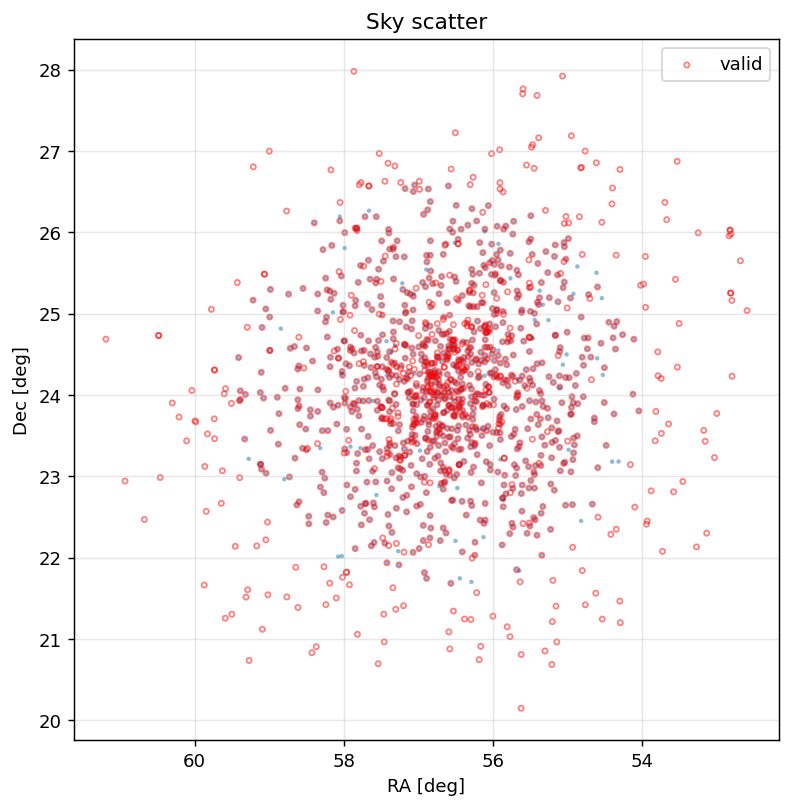

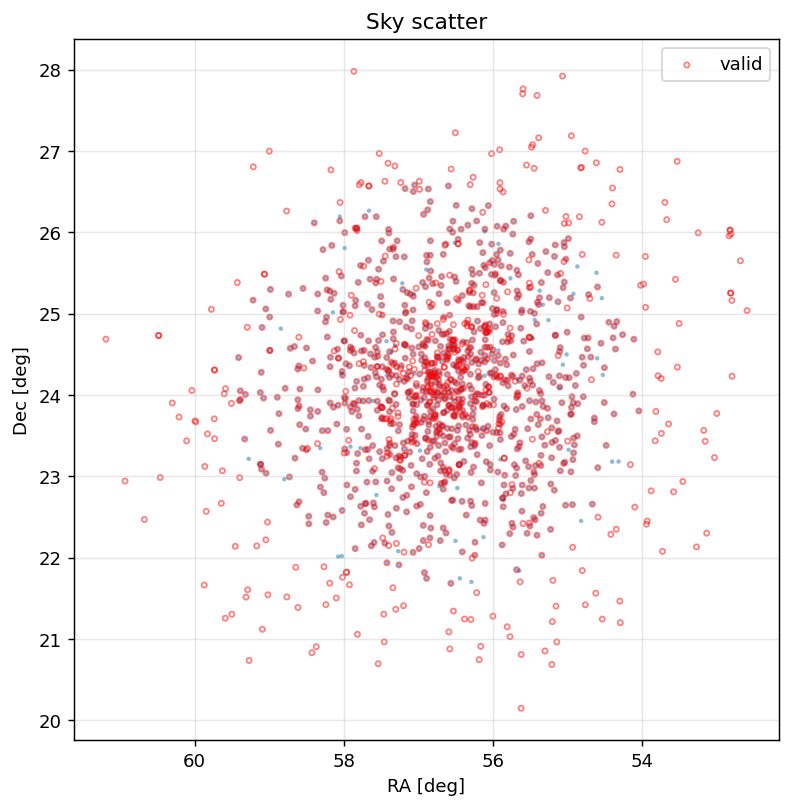

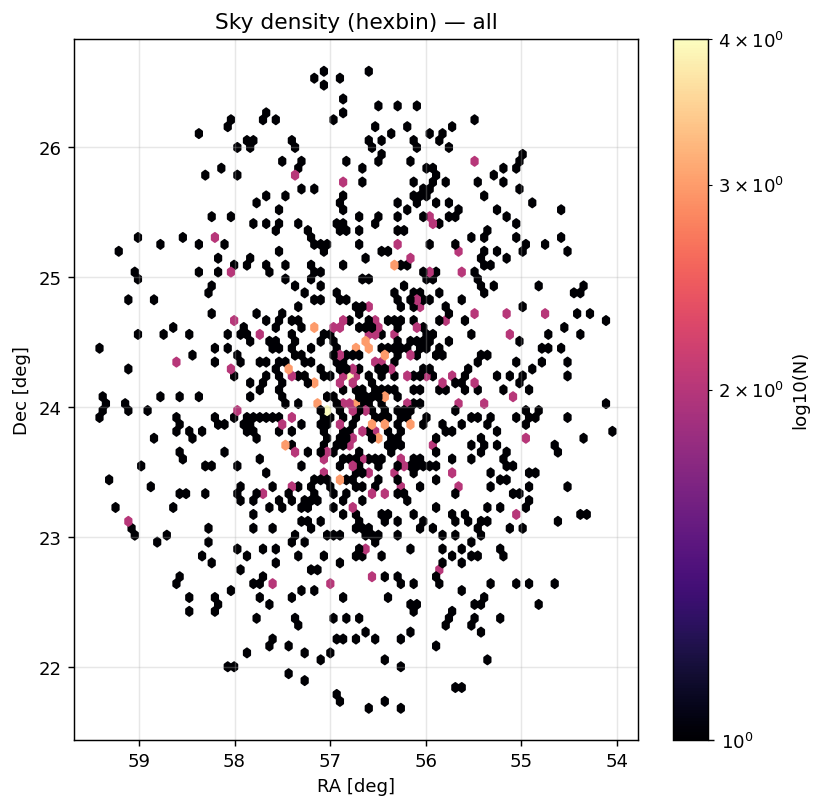

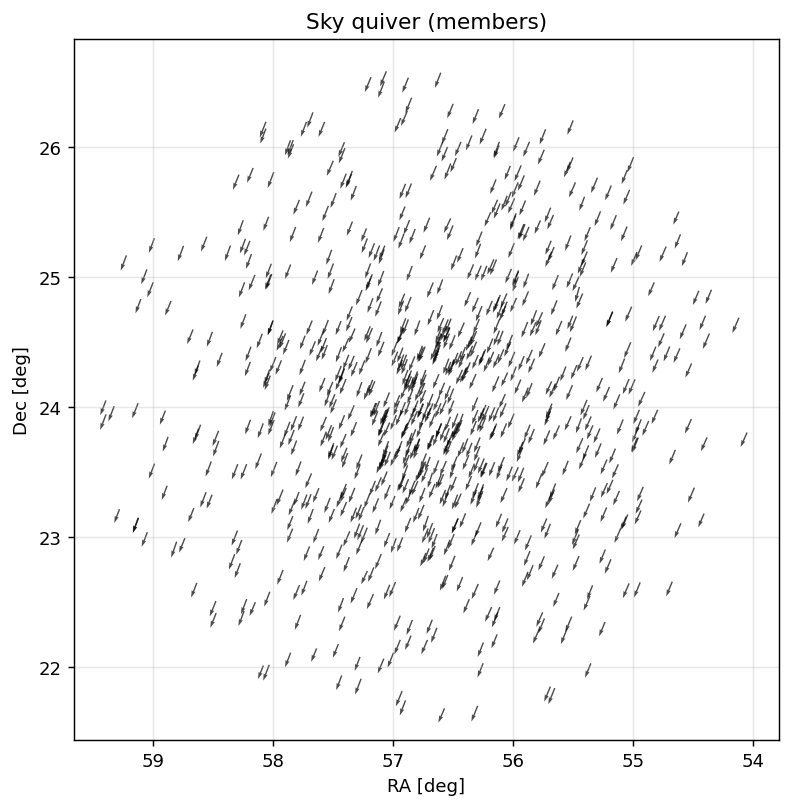

/mnt/e/IT/Machine_Learning/PROJECT/pleiades-hdbscan/src/pleiades/plotting.py:155: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(data["pmra"], data["pmdec"], s=6, alpha=0.6, c=c, cmap="plasma", edgecolors="none")


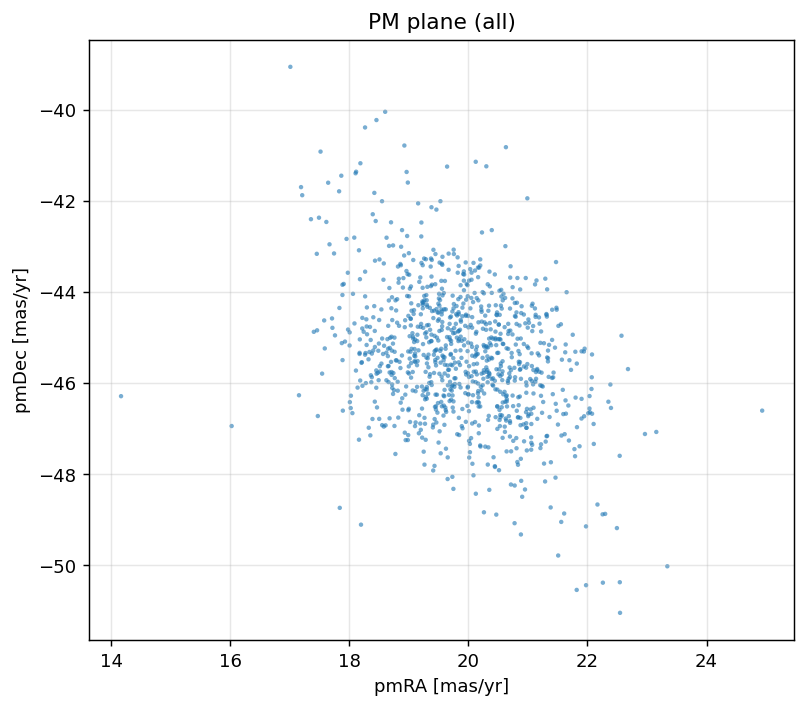

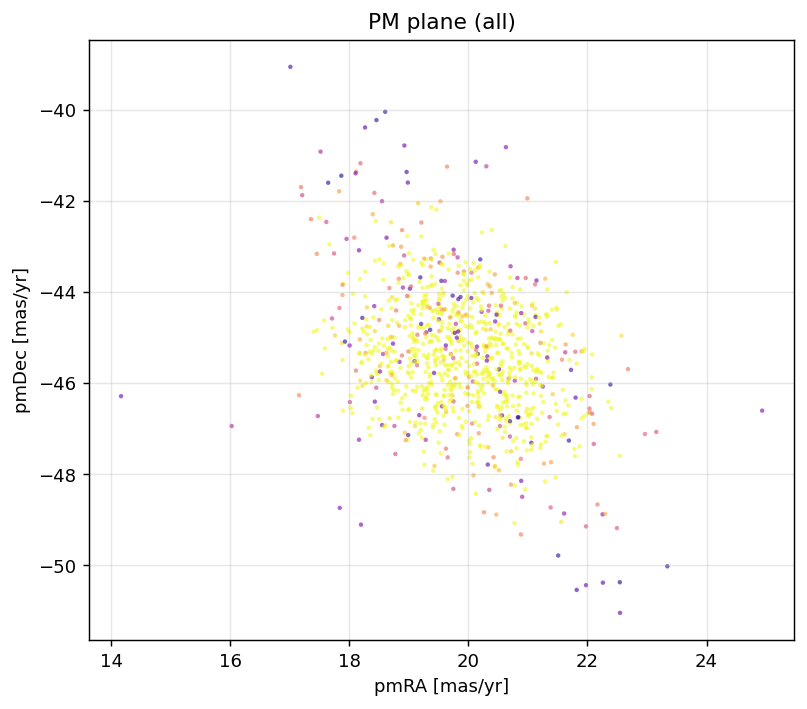

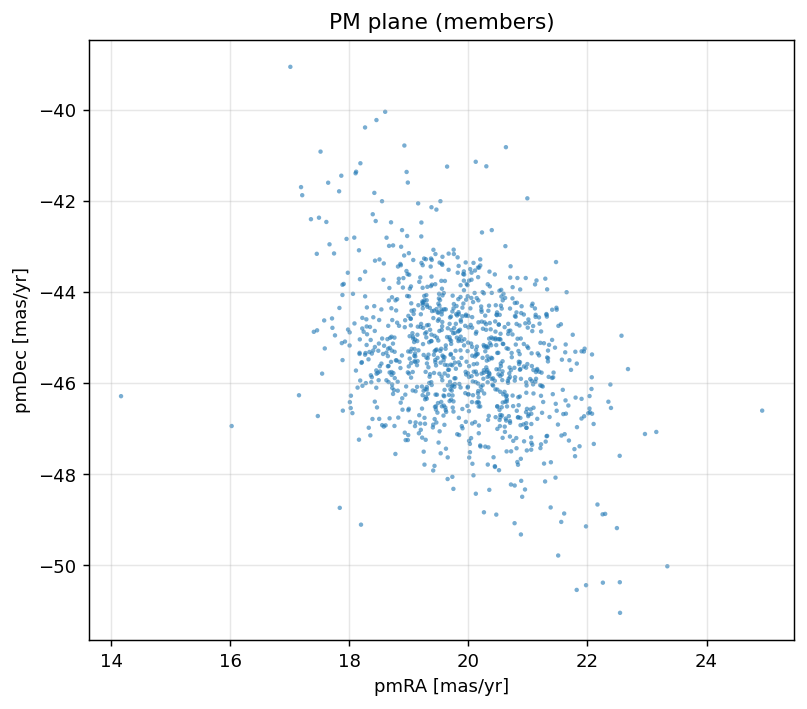

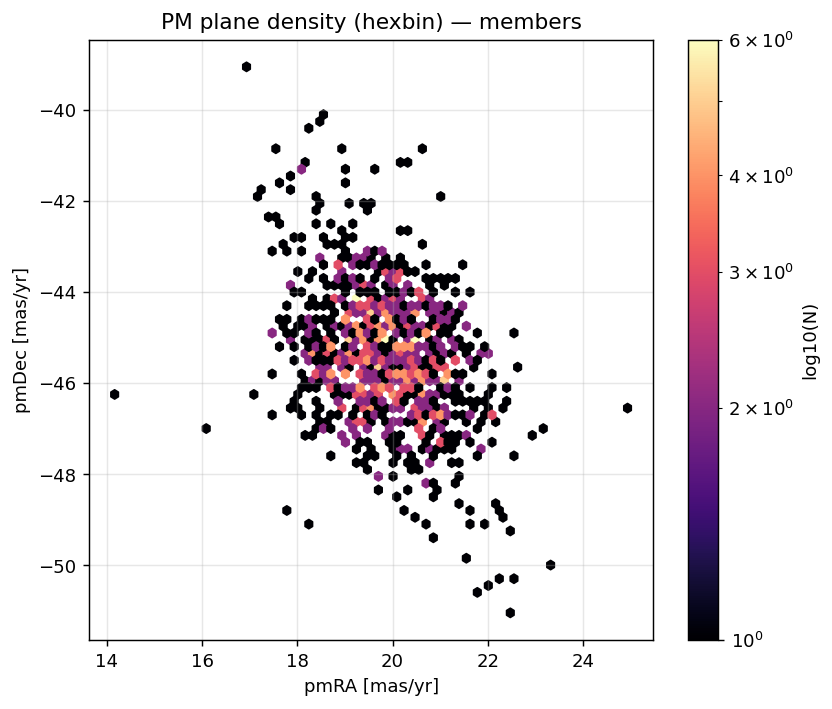

/mnt/e/IT/Machine_Learning/PROJECT/pleiades-hdbscan/src/pleiades/plotting.py:193: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(data["color"], data["M_G"], s=8, alpha=0.6, c=c, cmap="viridis", edgecolors="k", linewidths=0.2)


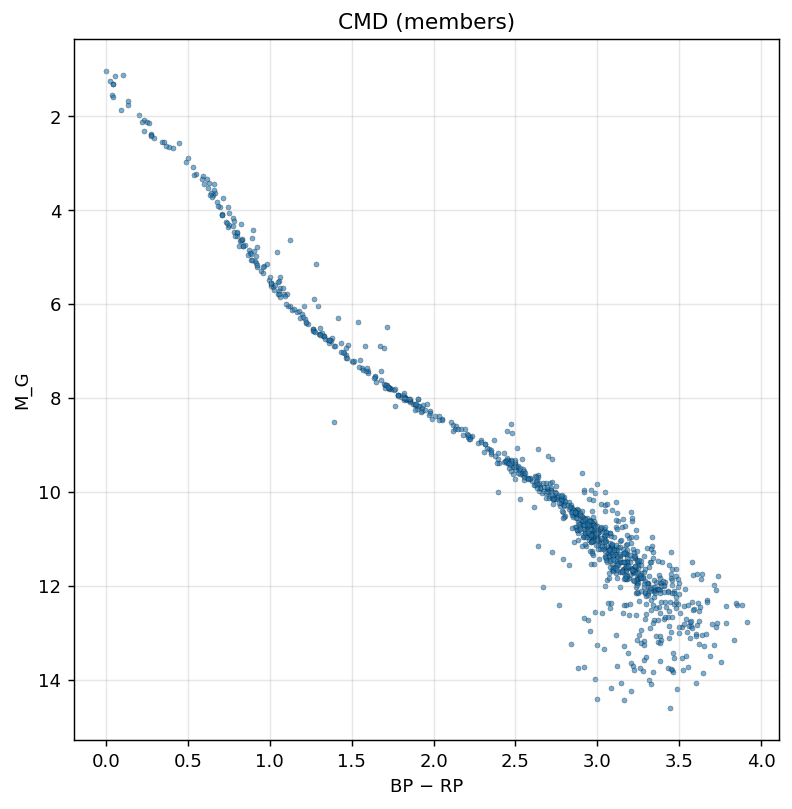

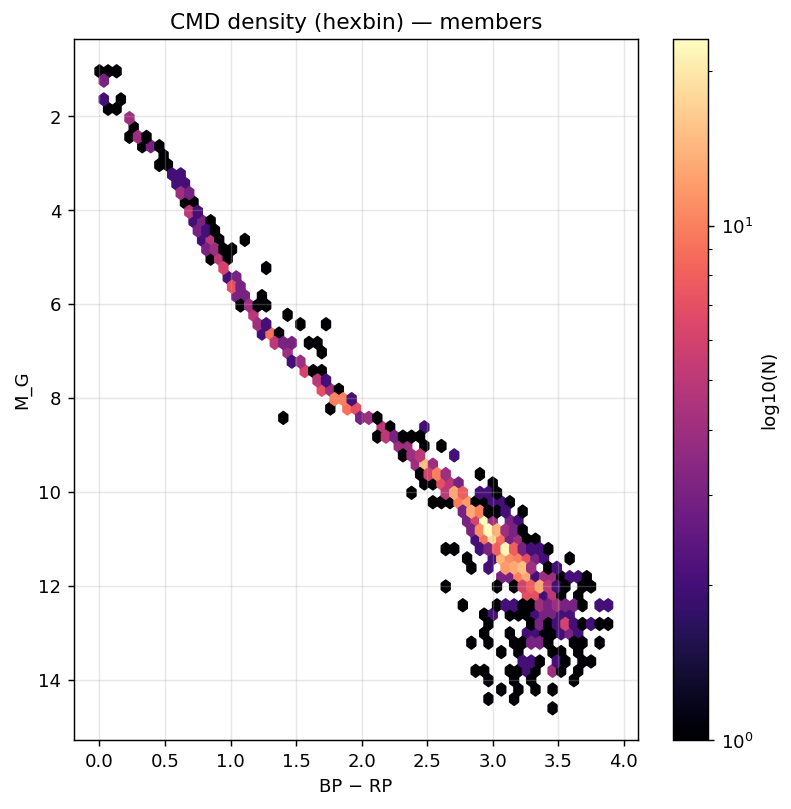

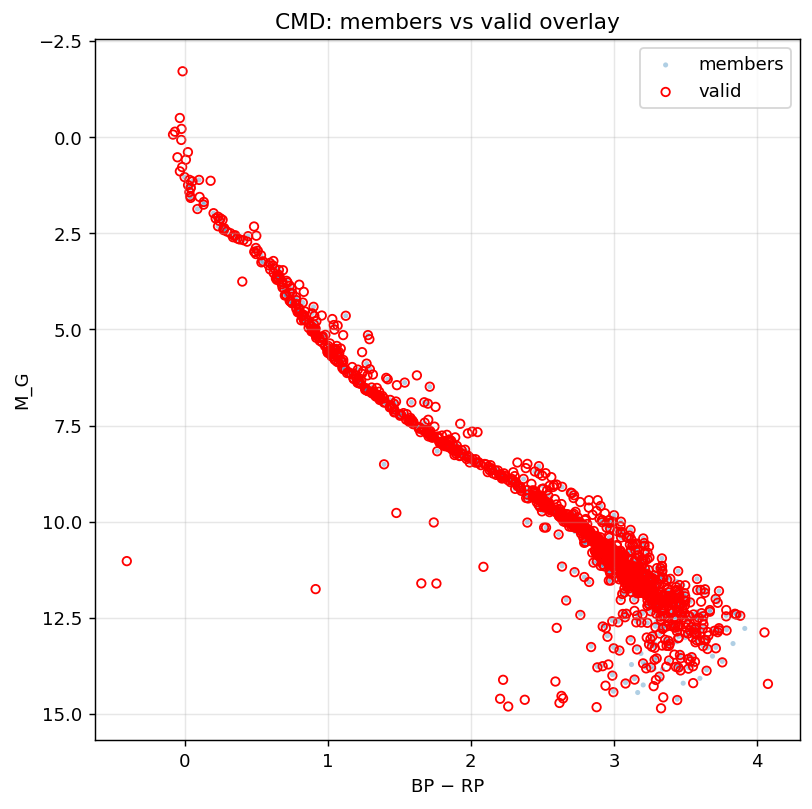

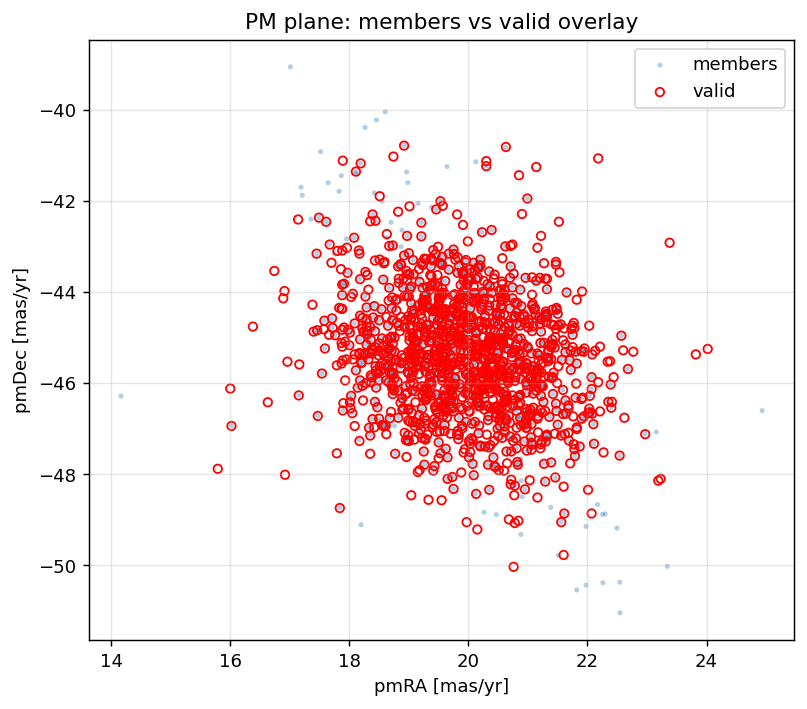

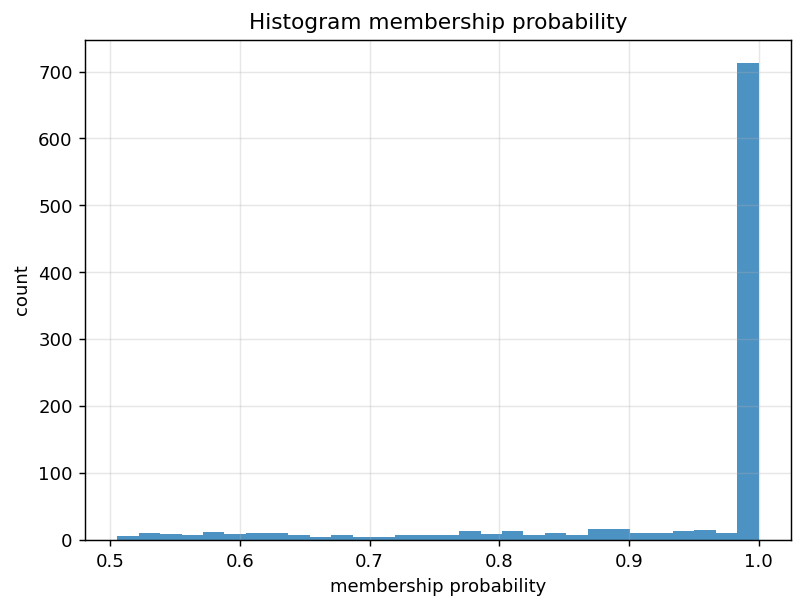

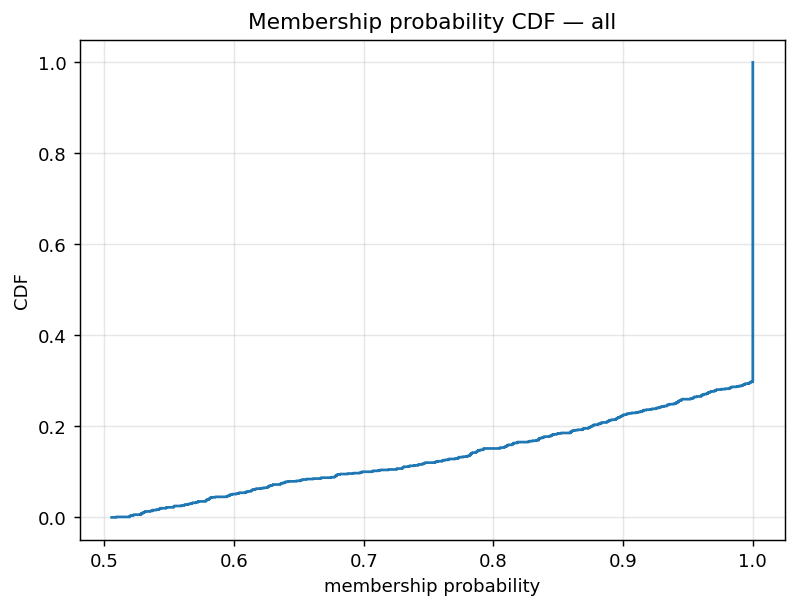

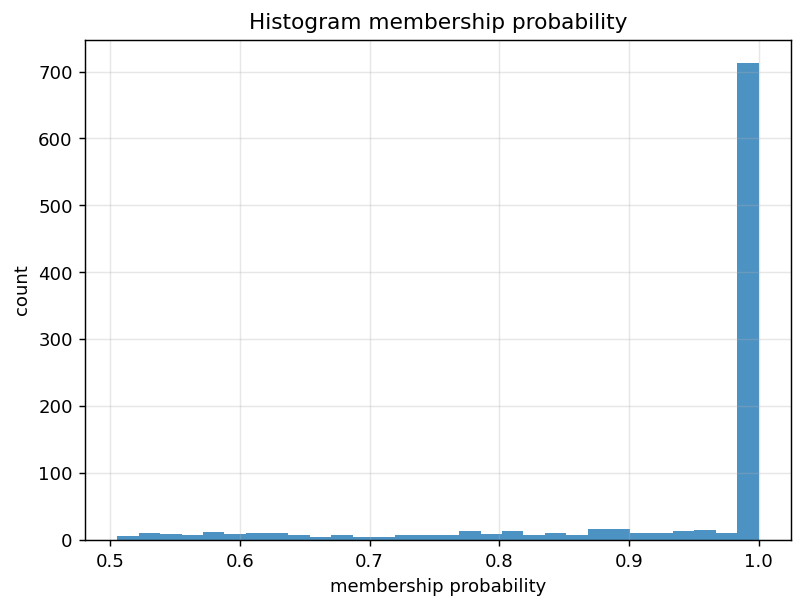

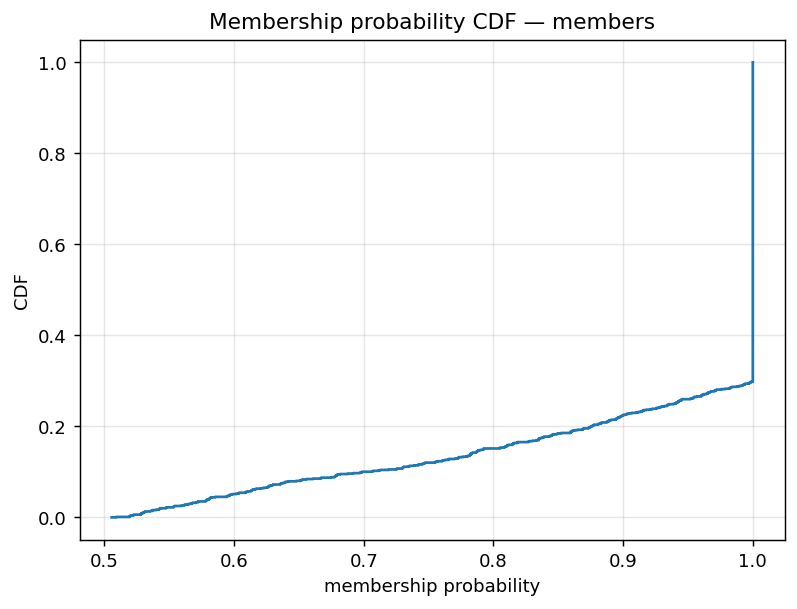

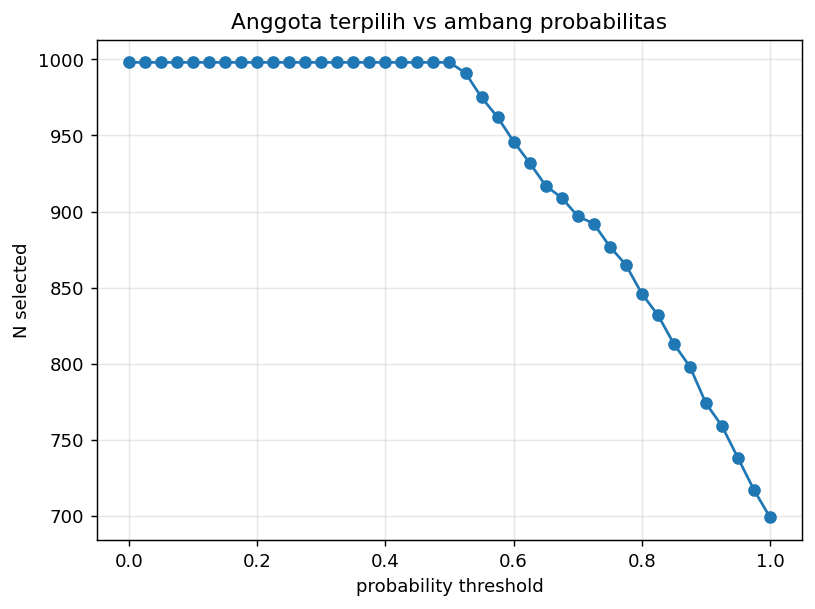

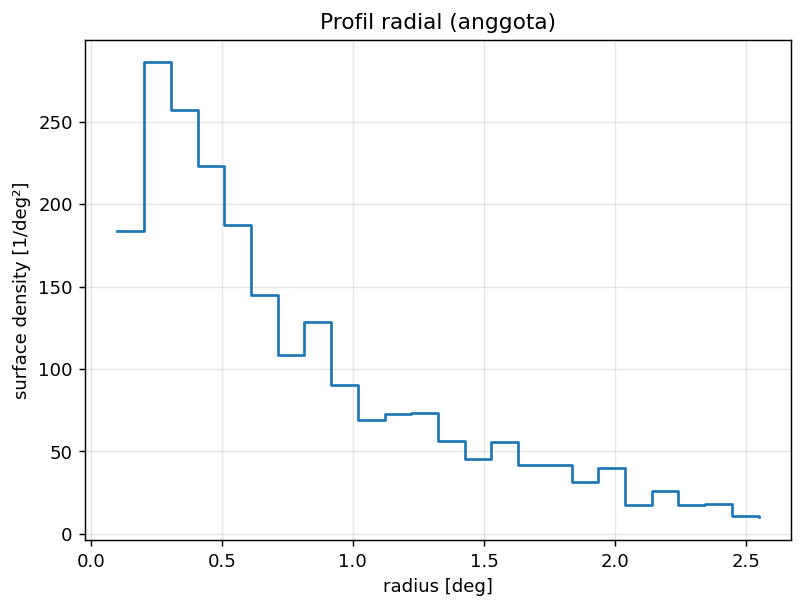

In [8]:
# SKY
P.plot_sky_scatter(df, members_only=False, color_by=None, valid=valid); plt.show()
P.plot_sky_scatter(df, members_only=True,  color_by=None, valid=valid); plt.show()
P.plot_sky_hexbin(df, members_only=False); plt.show()
P.plot_sky_quiver(df, members_only=True,  sample=int(CFG["plot"]["max_arrows"])); plt.show()

# PM PLANE
P.plot_pm_plane(df, members_only=False, color_by=None); plt.show()
if "prob" in df.columns:
    P.plot_pm_plane(df, members_only=False, color_by="prob"); plt.show()
P.plot_pm_plane(df, members_only=True,  color_by=None); plt.show()
P.plot_pm_plane_hexbin(df, members_only=True); plt.show()

# CMD
P.plot_cmd(df, members_only=True, color_by=None); plt.show()
P.plot_cmd_hexbin(df, members_only=True); plt.show()

if valid is not None:
    if {"color","M_G"} <= set(valid.columns):
        P.plot_overlay_cmd_with_valid(df[df["is_member"]], valid); plt.show()
    if {"pmra","pmdec"} <= set(valid.columns) and {"pmra","pmdec"} <= set(df.columns):
        P.plot_overlay_pm_with_valid(df[df["is_member"]], valid); plt.show()

# PROBABILITAS
if "prob" in df.columns:
    P.plot_probability_hist_cdf(df, members_only=False); plt.show()
    P.plot_probability_hist_cdf(df, members_only=True);  plt.show()
    P.plot_members_vs_threshold(df); plt.show()

# PROFIL RADIAL & RUWE
if {"ra","dec"} <= set(df.columns):
    P.plot_radial_profile(df, members_only=True, n_bins=25); plt.show()
ax = P.plot_ruwe_vs_g(df, members_only=True)
if ax is not None:
    plt.show()


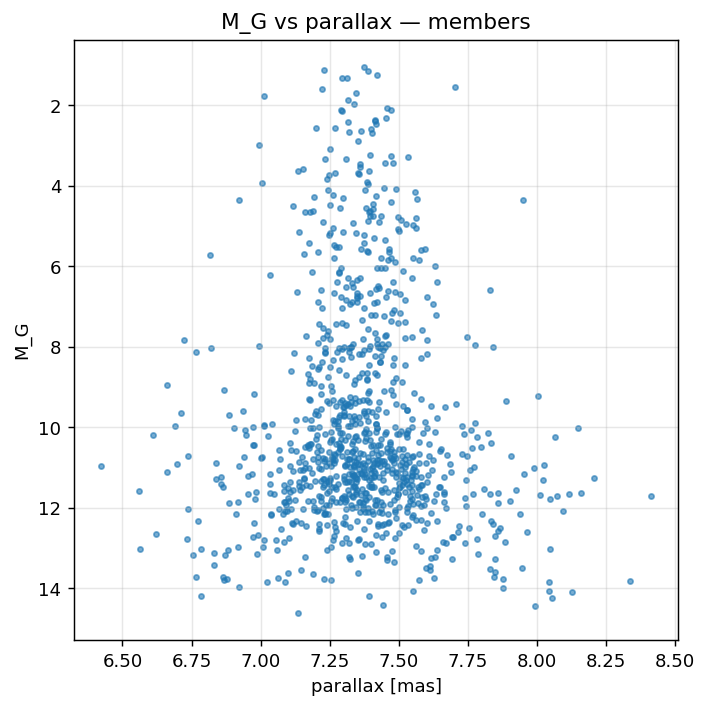

In [9]:
if {"parallax","M_G"} <= set(df.columns):
    fig, ax = plt.subplots(figsize=(6,6))
    sub = df[df["is_member"]]
    ax.scatter(sub["parallax"], sub["M_G"], s=8, alpha=0.6)
    ax.set_xlabel("parallax [mas]"); ax.set_ylabel("M_G")
    ax.invert_yaxis(); ax.grid(True, alpha=0.3)
    ax.set_title("M_G vs parallax — members")
    plt.show()


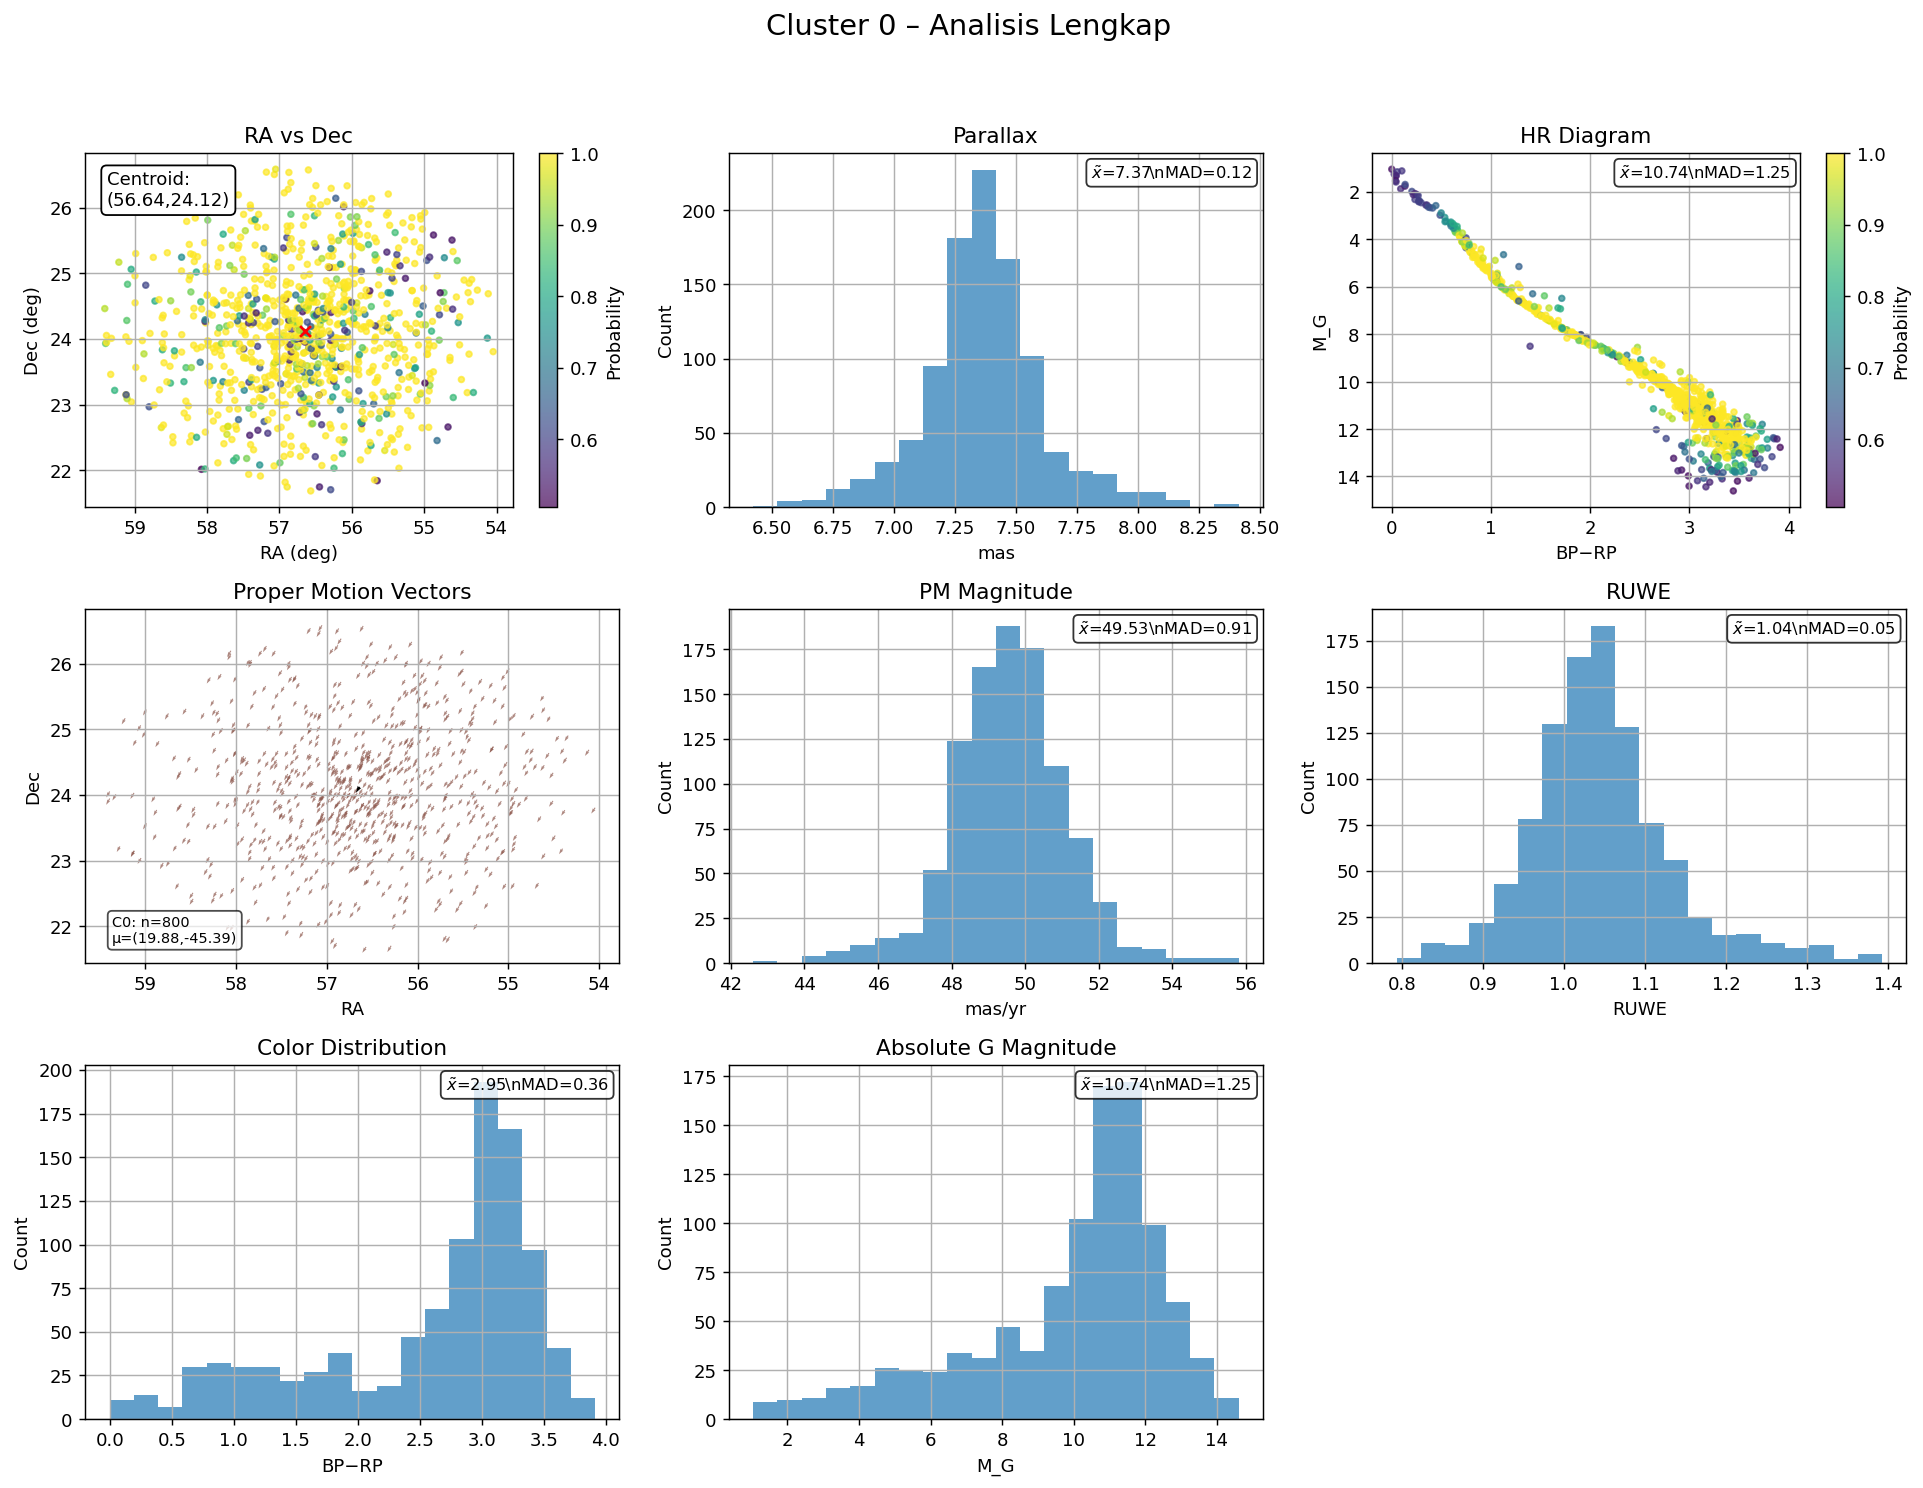

In [10]:
labels = sorted(df["cluster"].unique().tolist()) if "cluster" in df.columns else []
labels = [l for l in labels if l != -1] + ([-1] if -1 in labels else [])

if PANELS_FOR != "all":
    sel = [l for l in labels if l in set(PANELS_FOR)]
else:
    sizes = df["cluster"].value_counts().to_dict() if "cluster" in df.columns else {}
    non_noise = [l for l in labels if l != -1]
    non_noise.sort(key=lambda x: sizes.get(x, 0), reverse=True)
    sel = non_noise[:MAX_PANELS] + ([-1] if -1 in labels else [])

for lbl in sel:
    fig, _ = P.plot_panel_per_cluster(df, label=int(lbl), max_arrows=int(CFG["plot"]["max_arrows"]))
    plt.show()


In [11]:
feats_for_summary = [c for c in ["parallax","pmra","pmdec","color","M_G","ruwe","_pm_mag"] if c in df.columns]
try:
    ns = V.numeric_summary(df, label_col="cluster", features=feats_for_summary)
    display(ns)
except Exception as e:
    print("numeric_summary skip:", e)

try:
    cent = V.cluster_centroids(df, label_col="cluster", features=[c for c in ["pmra","pmdec","parallax","color","M_G"] if c in df.columns])
    display(cent)
except Exception as e:
    print("cluster_centroids skip:", e)


,parallax_count,parallax_mean,parallax_std,parallax_min,parallax_median,parallax_max,pmra_count,pmra_mean,pmra_std,pmra_min,pmra_median,pmra_max,pmdec_count,pmdec_mean,pmdec_std,pmdec_min,pmdec_median,pmdec_max,color_count,color_mean,color_std,color_min,color_median,color_max,M_G_count,M_G_mean,M_G_std,M_G_min,M_G_median,M_G_max,ruwe_count,ruwe_mean,ruwe_std,ruwe_min,ruwe_median,ruwe_max,_pm_mag_count,_pm_mag_mean,_pm_mag_std,_pm_mag_min,_pm_mag_median,_pm_mag_max
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,998,7.368393,0.244492,6.423569,7.366425,8.412299,998,19.880092,1.100678,14.165186,19.867312,24.935122,998,-45.389997,1.477004,-51.039598,-45.398319,-39.061663,998,2.577406,0.905859,0.000077,2.946656,3.913706,998,9.859694,2.771286,1.040324,10.741534,14.611799,998,1.04621,0.088244,0.793824,1.040834,1.392579,998,49.562195,1.565482,42.604317,49.525033,55.798085


,pmra_mean,pmdec_mean,parallax_mean,color_mean,M_G_mean
cluster,,,,,
0,19.880092,-45.389997,7.368393,2.577406,9.859694


In [12]:
if valid is not None:
    try:
        comp = V.compare_to_valid_global(df[df["is_member"]], valid)
        display(comp)
    except Exception as e:
        warnings.warn(f"Gagal bandingkan ke valid: {e!r}")


parallax_mean_cluster     7.368393
parallax_mean_valid       7.372044
parallax_mean_diff       -0.003651
pm_mag_mean_cluster      49.562195
pm_mag_mean_valid        49.589551
pm_mag_mean_diff         -0.027356
pm_angle_diff_deg         0.031092
color_mean_cluster        2.577406
color_mean_valid          2.466205
color_mean_diff           0.111201
M_G_mean_cluster          9.859694
M_G_mean_valid            9.541917
M_G_mean_diff             0.317777
dtype: float64

In [13]:
if SAVE_MEMBERS:
    cols_order = [c for c in ["source_id","ra","dec","parallax","pmra","pmdec","color","M_G","ruwe","prob","cluster"] if c in df.columns]
    members = df[df["is_member"]].copy()
    if "prob" in members.columns:
        members = members.sort_values("prob", ascending=False)
    EXPORT_PATH.parent.mkdir(parents=True, exist_ok=True)
    members[cols_order].to_csv(EXPORT_PATH, index=False)
    print(f"[DONE] Anggota final diekspor → {EXPORT_PATH} (n={len(members)})")
    display(members.head(10))
else:
    print("SAVE_MEMBERS=False, ekspor di-skip.")


[DONE] Anggota final diekspor → data/processed/pleiades_members_final.csv (n=998)


,ra,dec,parallax,pmra,pmdec,g,bp,rp,ruwe,color,M_G,cluster,prob,is_member,is_pleiades,_pm_mag
996,57.069393,26.503112,7.771877,20.775924,-49.073058,16.525291,18.279528,15.256958,1.016582,3.022570,10.977921,0,1.0,True,True,53.289812
0,58.268967,22.801153,7.293433,19.036700,-45.560948,13.100869,13.850247,12.250756,1.044438,1.599491,7.415529,0,1.0,True,True,49.378092
1,58.315505,22.870487,7.730451,19.499144,-47.304899,15.532084,17.030619,14.332068,1.087538,2.698552,9.973108,0,1.0,True,True,51.166103
2,58.256849,22.979900,7.420786,18.679104,-45.228349,16.564484,18.348476,15.292191,1.047237,3.056285,10.916734,0,1.0,True,True,48.933756
3,58.292407,23.052791,7.339354,19.736553,-46.536112,15.395707,16.808872,14.223000,1.062630,2.585872,9.723996,0,1.0,True,True,50.548405
980,55.044632,25.824831,7.083080,18.865773,-43.413899,17.180622,18.992939,15.896719,1.020439,3.096220,11.431733,0,1.0,True,True,47.335864
979,55.496218,25.920718,7.291083,20.577735,-45.137358,12.449474,13.063317,11.700975,1.087875,1.362342,6.763434,0,1.0,True,True,49.606695
978,55.168079,25.846594,7.256146,20.865653,-45.707460,16.019033,17.624360,14.792358,1.014686,2.832002,10.322563,0,1.0,True,True,50.244874
977,55.292875,25.765419,7.797466,21.563527,-47.149997,16.040766,17.695215,14.802626,1.048714,2.892589,10.500534,0,1.0,True,True,51.846967
976,55.177478,25.705268,7.396324,20.785016,-45.870990,12.313311,12.895205,11.586379,1.145945,1.308826,6.658391,0,1.0,True,True,50.360347


In [ ]:
# panggil skrip CLI untuk membuat seluruh figur PNG ke data/processed/figures
import subprocess, shlex

cmd = f"python scripts/04_make_figures.py --config {CONFIG_PATH} --skip-condensed"

print("[RUN]", cmd)
proc = subprocess.run(shlex.split(cmd), capture_output=True, text=True)
print(proc.stdout)
print(proc.stderr)


[RUN] python scripts/04_make_figures.py --config configs/default.yaml --skip-condensed
[INFO] Memuat hasil klaster: pleiades_members_final.csv
[INFO] n=998; members (prob>=0.5 & cluster>=0): 998
[INFO] Memuat valid: valid_clean.csv
[NOTE] File hasil tampaknya hanya berisi anggota (members-only). Plot 'all' dan 'members' akan identik. Jika ingin bandingkan dengan field/noise, jalankan dengan --input ke file hasil lengkap.
[PLOT] sky_scatter_all.png
[PLOT] sky_scatter_members.png
[PLOT] sky_scatter_prob_all.png
[PLOT] sky_scatter_prob_members.png
[PLOT] sky_hexbin_all.png
[PLOT] sky_quiver_members.png
[PLOT] pm_plane_all.png
[PLOT] pm_plane_prob_all.png
[PLOT] pm_plane_members.png
[PLOT] pm_plane_hexbin_members.png
[PLOT] cmd_members.png
[PLOT] cmd_hexbin_members.png
[PLOT] cmd_members_vs_valid.png
[PLOT] pm_plane_members_vs_valid.png
[PLOT] mg_vs_parallax_members.png
[PLOT] hist_pmra.png
[PLOT] hist_pmdec.png
[PLOT] hist_parallax.png
[PLOT] hist_color.png
[PLOT] hist_M_G.png
[PLOT] hist

## Kamus Kolom

- `ra`, `dec` — koordinat langit (deg; RA dibalik di plot).
- `pmra`, `pmdec` — proper motion (mas/yr).
- `parallax` — paralaks (mas).
- `phot_g_mean_mag` — magnitudo Gaia G (mag).
- `color` — BP−RP.
- `M_G` — magnitudo absolut G (mag).
- `ruwe` — kualitas astrometri (Renormalised Unit Weight Error).
- `cluster` — label HDBSCAN (−1 = noise).
- `prob` — probabilitas keanggotaan dari HDBSCAN.
- `is_member` — flag anggota (gabungan label & ambang `prob`).
- `_pm_mag` — √(pmra² + pmdec²).
